### Importation des librairies

In [1]:
%%capture capt
!pip install lifelines
!pip install tqdm
!pip install numpy==1.22
from tqdm import tqdm
import numpy as np
import pandas as pd
from lifelines.statistics import proportional_hazard_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic as diag
import seaborn as sns


### Base cluster unsupervised

In [2]:
profil_patient= pd.read_csv('../data/grid_search/filter_20_10_5.csv')
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster1,cluster2,cluster3,cluster4,cluster5,p_soins,Nb_jours_moyen
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,...,1,1,1,0,0,0,1,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...",2.555556
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,...,2,1,1,0,0,0,1,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...",6.375000
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,...,0,1,1,0,1,0,0,0,"11M041,06C194",14.333333
3,P13,2011-05-19,57,974,1,NaN,False,2783,2,0,...,0,1,0,0,1,0,0,0,"05M04T,05K051",1.500000
4,P16,2010-03-18,69,76,1,NaN,False,3210,9,0,...,1,1,1,0,0,0,1,0,"08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1...",3.111111


### Test Log-Rank

#### Entre clusters non supervisés

In [4]:
nb_cluster=5

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

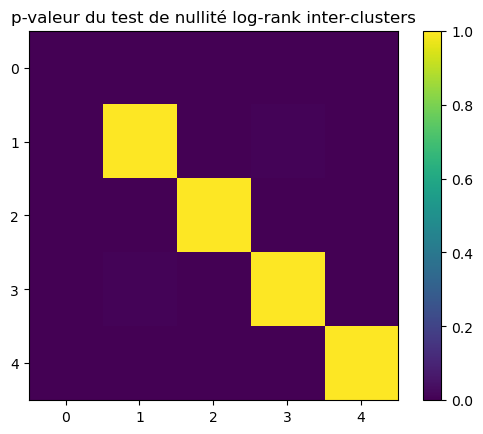

In [5]:
Matrice=np.zeros((nb_cluster,nb_cluster))
for i in range (1,nb_cluster):
    for j in range (1,nb_cluster):
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['cluster' + str(i)]==1], profil_patient['Nb_survie'][profil_patient['cluster' + str(j)]==1], event_observed_A=profil_patient['Mort'][profil_patient['cluster' + str(i)]==1], event_observed_B=profil_patient['Mort'][profil_patient['cluster' + str(j)]==1])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

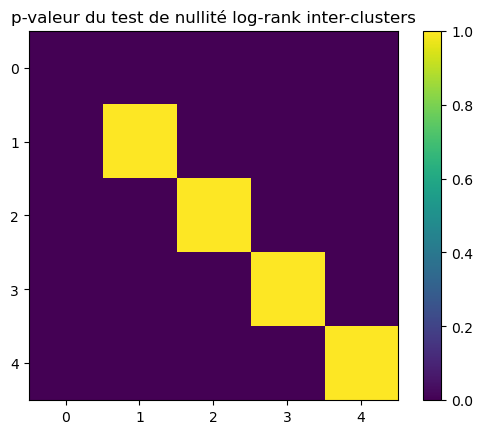

In [6]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

#### Choc ou pas choc

p-valeur CHOC/PAS CHOC =
1.0571089917174136e-10


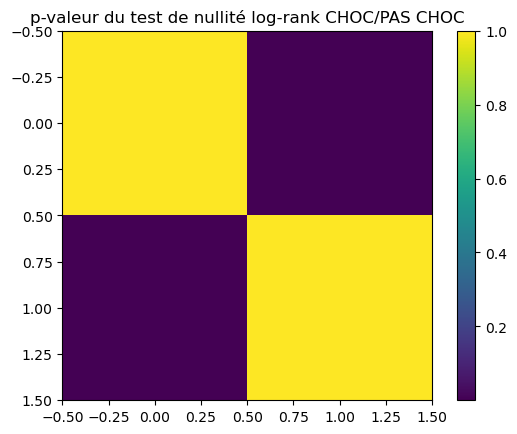

In [7]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i
        cluster_j=j
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_i], profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")
print("p-valeur CHOC/PAS CHOC =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==0], profil_patient['Nb_survie'][profil_patient['CHOC']==1], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==0], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==1]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

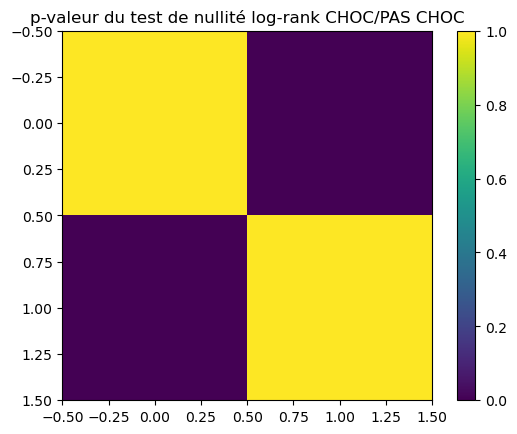

In [8]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

#### Homme ou femme

p-valeur HOMME/FEMME =
0.004273345157189191


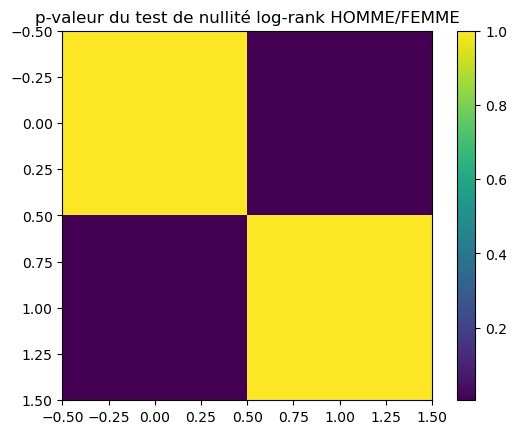

In [9]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i+1
        cluster_j=j+1
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_i], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank HOMME/FEMME")
print("p-valeur HOMME/FEMME =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==1], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==2], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==1], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==2]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

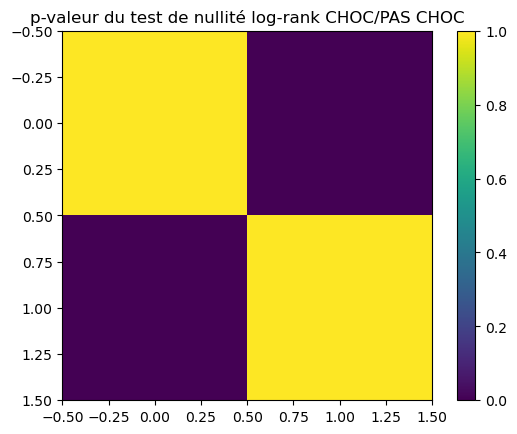

In [10]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

### Test COX en extrayant les patients pour chaque cluster

In [14]:
Nb_cluster=nb_cluster
profil_patient=pd.read_csv('../data/grid_search/filter_20_10_5.csv')
#profil_patient=profil_patient.dropna()
profil_patient=profil_patient.drop_duplicates()

profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient['Nb_jours_moyen']=np.round(profil_patient['Nb_jours_moyen'], 1)
profil_patient=profil_patient.drop(['CODE_PATIENT', 'date_h0', 'BEN_RES_DPT','dte_deces', 'cat_age', 'cat_nb_hospit','cat_nb_jours_sej', 'p_soins', 'Nb_hospit', 'Nb_jours_sej'], axis=1)
profil_patient=profil_patient.dropna()
profil_patient=profil_patient.drop_duplicates()
profil_patient.head()

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,cluster1,cluster2,cluster3,cluster4,cluster5,Nb_jours_moyen
0,67,1,False,2596,0,0,0,0,1,0,2.6
1,87,2,True,456,0,0,0,0,1,0,6.4
2,49,2,True,41,1,0,1,0,0,0,14.3
3,57,1,False,2783,0,0,1,0,0,0,1.5
4,69,1,False,3210,0,0,0,0,1,0,3.1


In [15]:
data_train, data_test = train_test_split(profil_patient, 
                                                    test_size=0.2)


In [16]:
data_train.head()

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,cluster1,cluster2,cluster3,cluster4,cluster5,Nb_jours_moyen
3868,97,1,True,113,0,0,1,0,0,0,20.4
3770,90,1,True,7,0,0,1,0,0,0,11.7
2876,92,2,True,19,0,0,1,0,0,0,13.4
3771,62,1,False,2775,0,1,0,0,0,0,2.2
1680,96,2,True,1791,0,0,0,0,1,0,6.7


In [17]:
def extract_cluster_i(i,data,Nb_cluster):
    data_train_cluster=data[data['cluster' + str(i)]==1].copy()
    for j in range(1,Nb_cluster+1):
        data_train_cluster=data_train_cluster.drop(['cluster' + str(j)], axis=1)
    data_train_cluster=data_train_cluster.drop_duplicates()
    data_train_cluster=data_train_cluster.dropna()
    return data_train_cluster

In [18]:
data_train_cluster= extract_cluster_i(1,data_train, Nb_cluster)
data_train_cluster

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,Nb_jours_moyen
3771,62,1,False,2775,0,2.2
3540,77,1,False,2090,1,3.5
4556,84,1,True,303,0,7.1
9234,71,2,False,1754,0,2.6
9002,90,2,True,112,0,5.8
...,...,...,...,...,...,...
6428,70,2,False,1132,0,4.1
7894,80,1,True,66,0,4.2
3766,77,2,False,1845,0,4.6
6657,84,2,True,1865,0,3.8


In [19]:
%%capture capt
#On définit nos variables
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
Variables_sans_CHOC=['y_nais','BEN_SEX_COD','Nb_jours_moyen']
data_train_cluster= extract_cluster_i(1,data_train, Nb_cluster)

if data_train_cluster['CHOC'].nunique()==1:
    data_train_cluster=data_train_cluster.drop(['CHOC'], axis=1)

cph = CoxPHFitter()
cph.fit(data_train_cluster, duration_col='Nb_survie', event_col='Mort')

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))

if data_train_cluster['CHOC'].nunique()==1:
    var=Variables_sans_CHOC
    #Courbe de survie:
    cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD'], values=[0,1], cmap='coolwarm', ax=ax1)
    fig.suptitle("Courbe de survie pour le cluster : " + str(1))
else:
    var=Variables
    #Courbe de survie:
    cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm', ax=ax1)
    fig.suptitle("Courbe de survie pour le cluster : " + str(1))
    
#Courbe de survie:
Liste_quantile=[0,.25, .5, .75,1]
Age=data_train_cluster['y_nais'].quantile(Liste_quantile)
Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
cph.plot_partial_effects_on_outcome(covariates=['y_nais'], values=Age, cmap='coolwarm', ax=ax2)

#Courbe de survie:
Liste_quantile=[0,.25, .5, .75,1]
Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
cph.plot_partial_effects_on_outcome(covariates=['Nb_jours_moyen'], values=Nb_jours, cmap='coolwarm', ax=ax3)

#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
for variable in var:
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
    


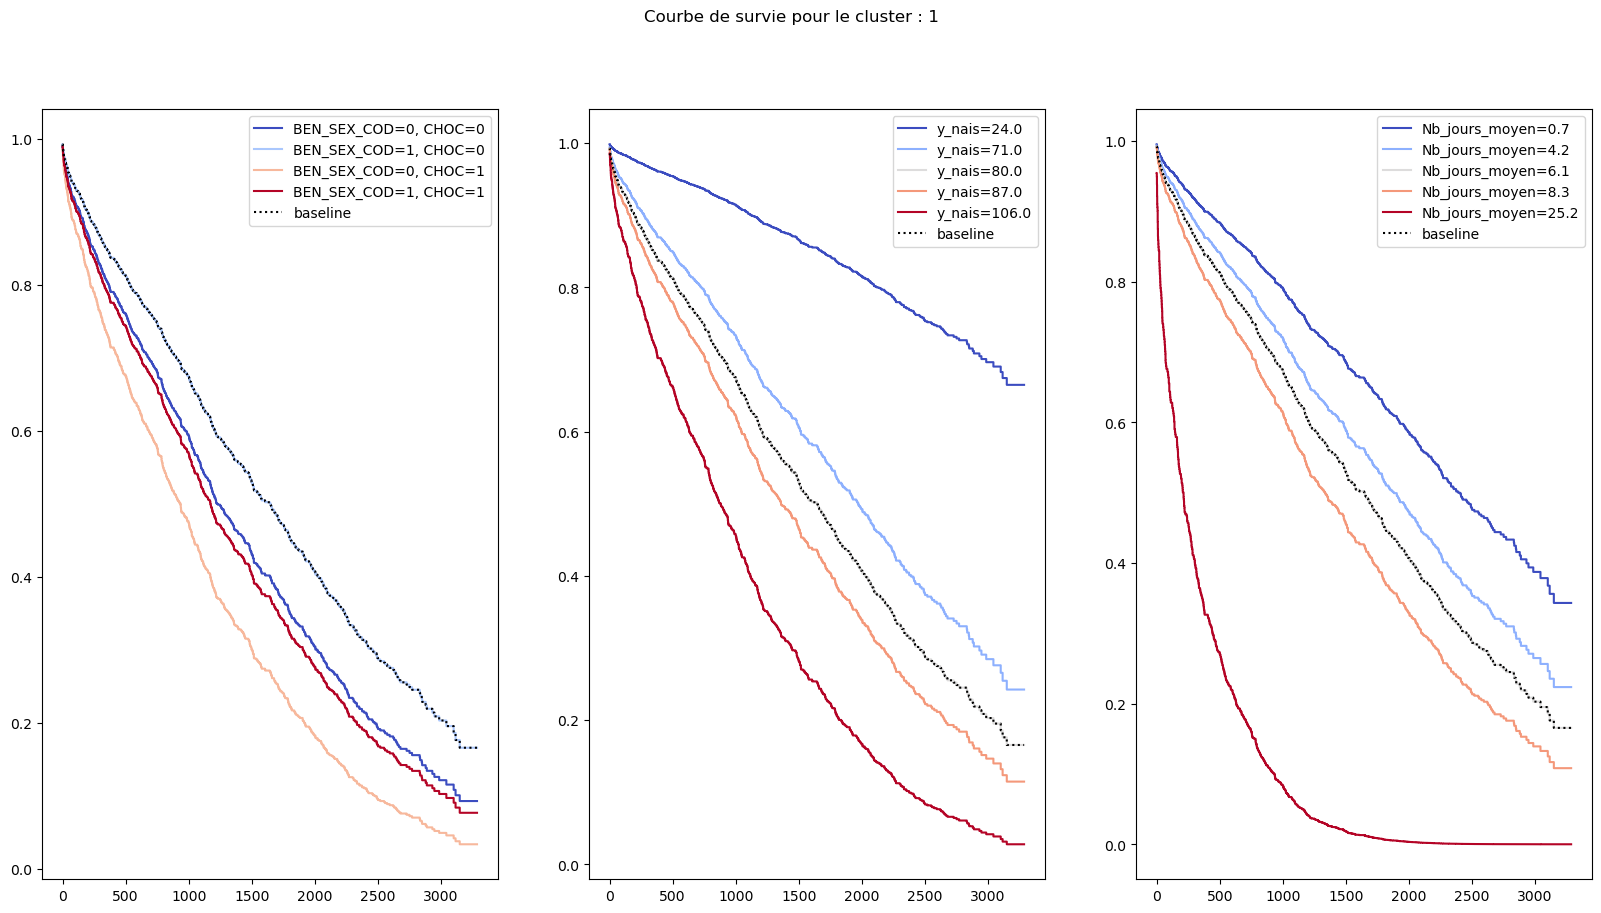

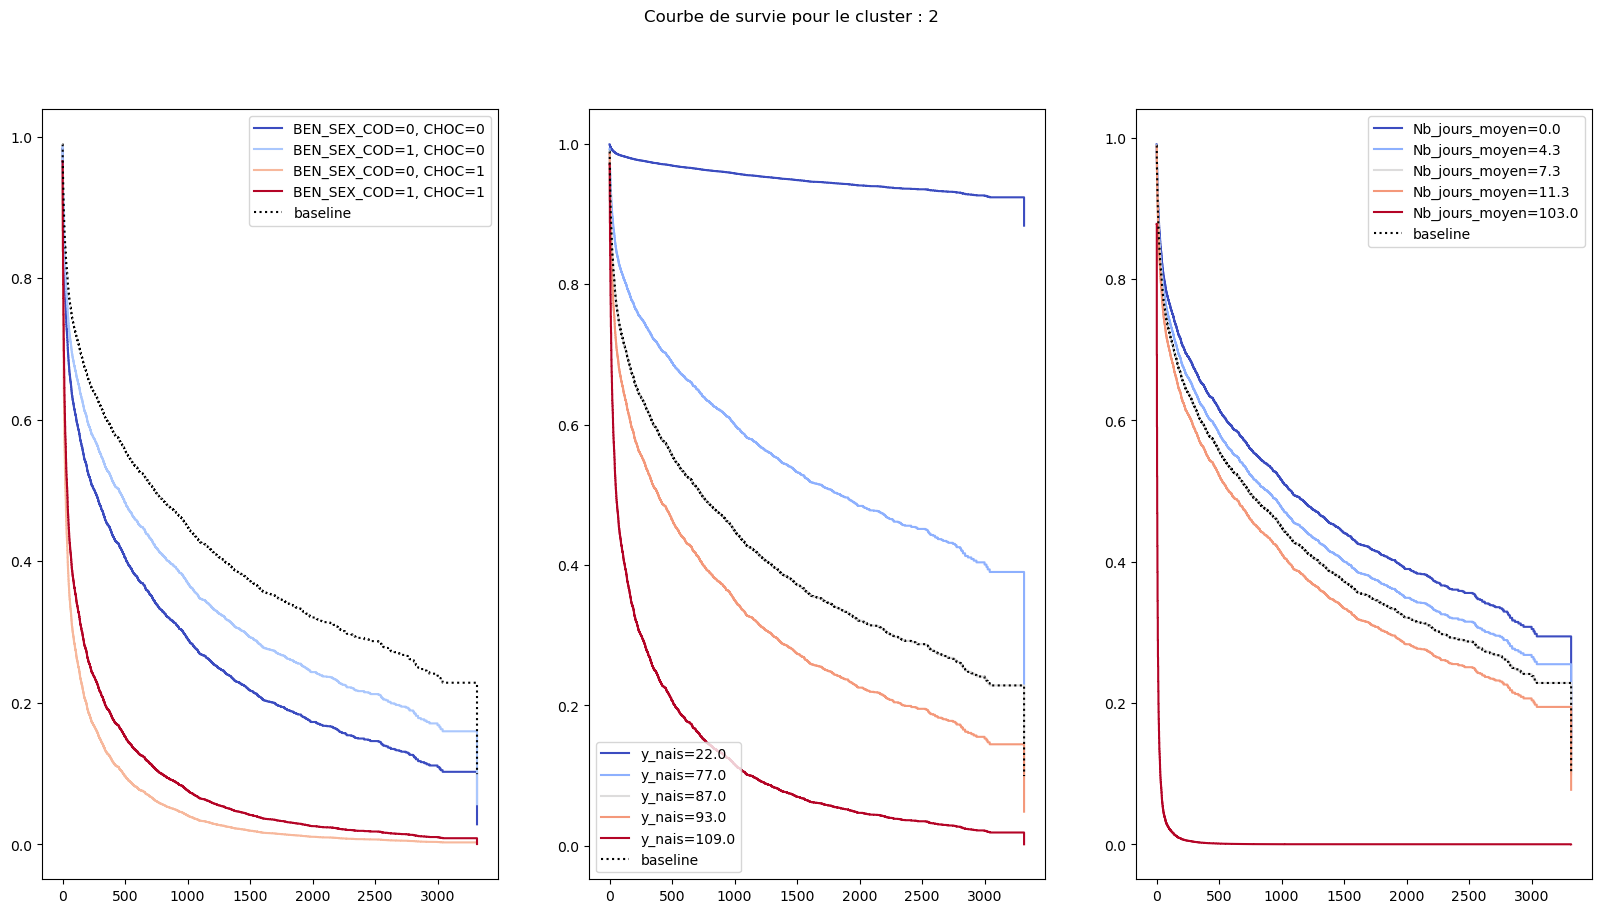

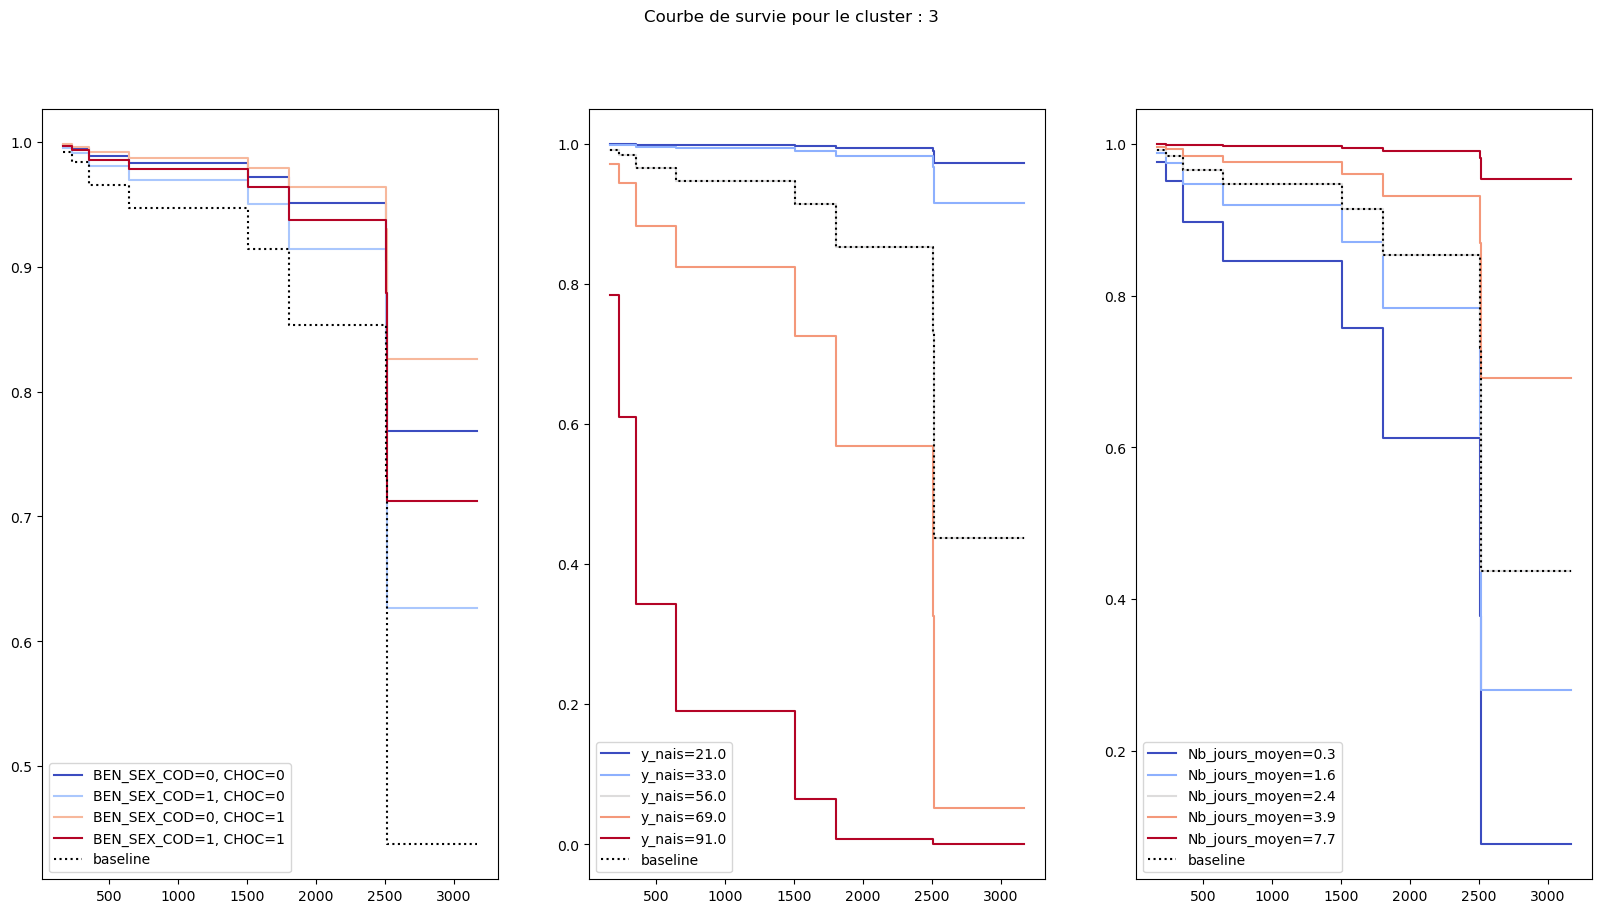

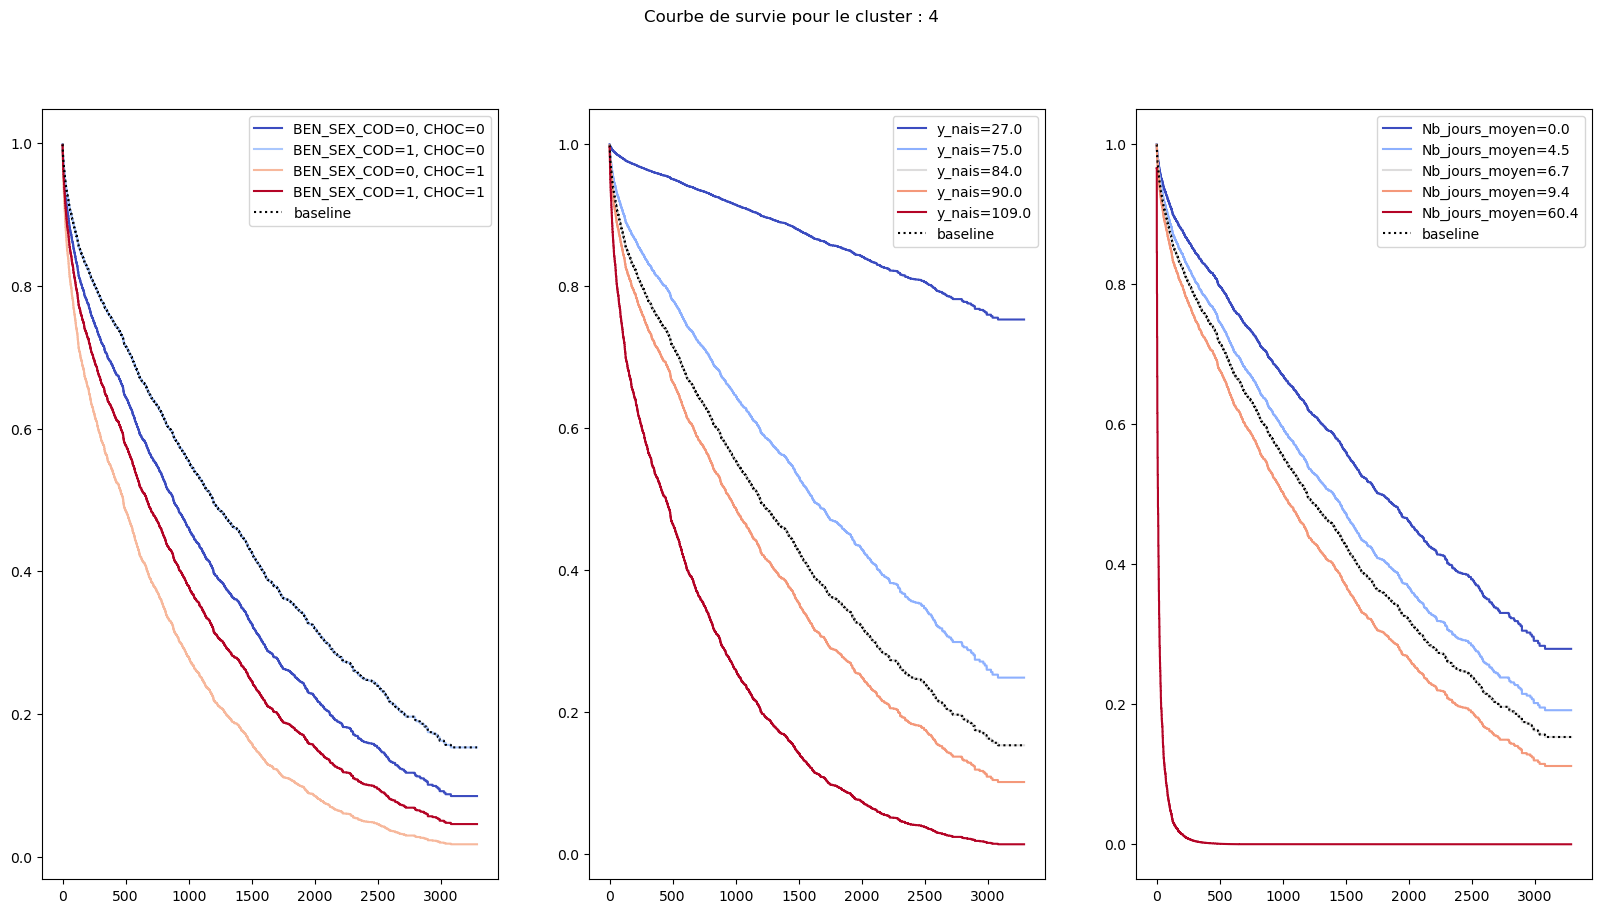

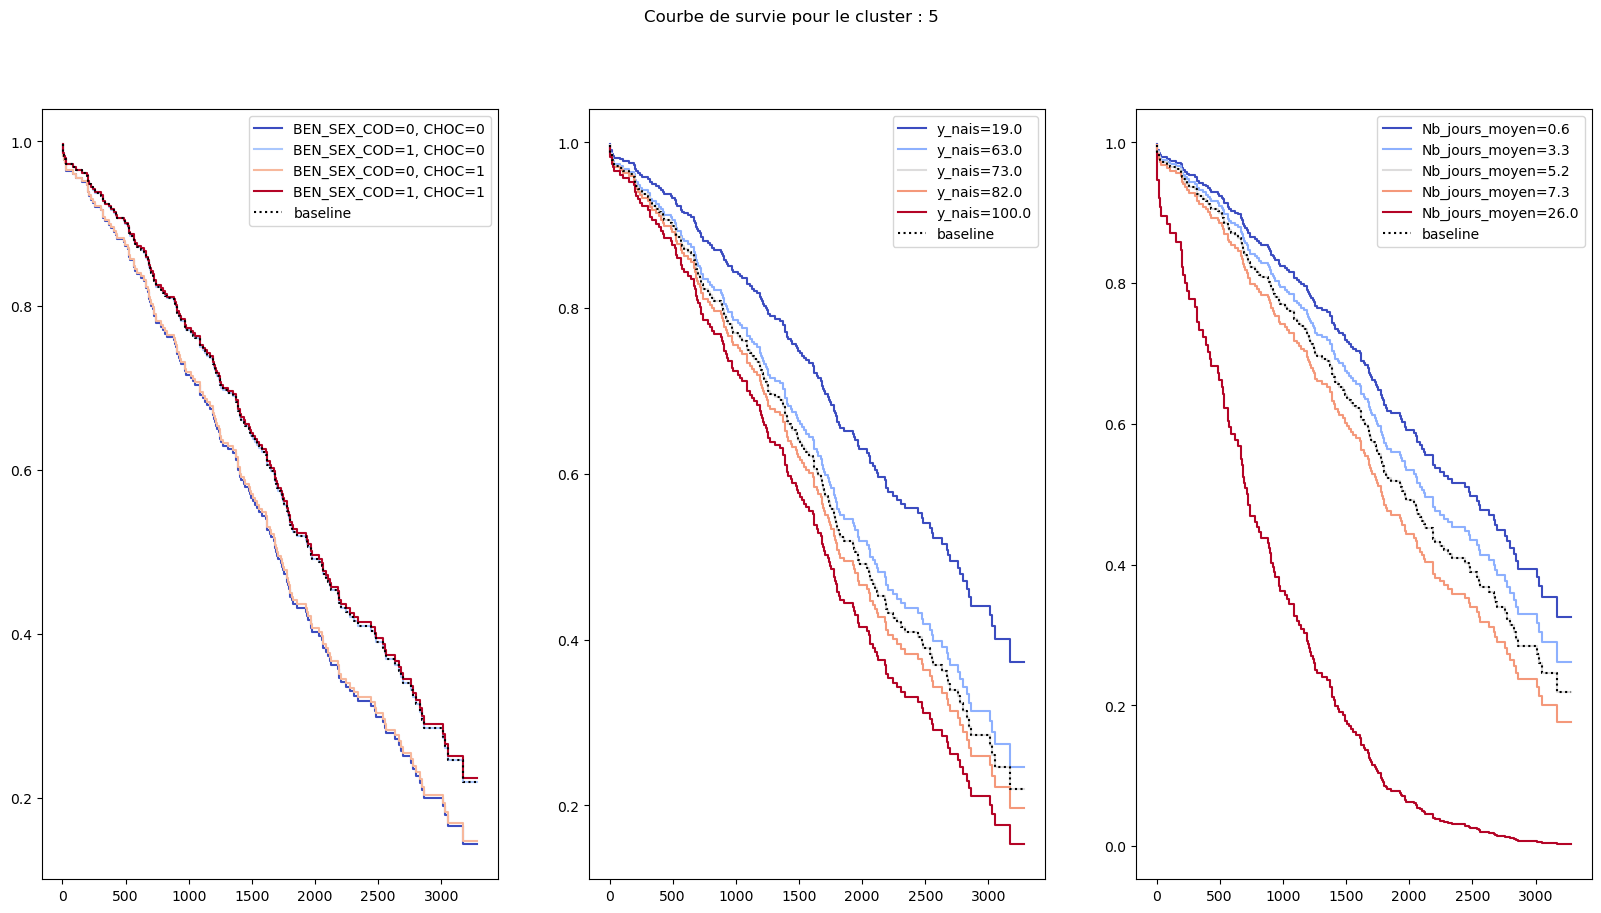

In [20]:

Bool=False
#A enlever pour obtenir les sorties et les plots
#On définit nos variables
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
Variables_sans_CHOC=['y_nais','BEN_SEX_COD','Nb_jours_moyen']
#P_valeur en dataframe : on extrait et on rename
P_Value=cph.summary.rename(columns={"p": "p_valeur_cluster_"+ str(1)})['p_valeur_cluster_1']
#AIC en liste
Partial_AIC=[]
#Interval de confiance en datafame on extrait et on rename au bon format
df1=cph.summary[['coef lower 95%', 'coef upper 95%']]
Liste_interval=df1.copy()
for i in range (len(df1['coef lower 95%'])):
    Liste_interval.iloc[i]="[" + str(np.around(df1['coef lower 95%'][i],decimals=2)) + " ," + str(np.around(df1['coef upper 95%'][i], decimals=2)) + "]"
Liste_interval=Liste_interval.drop(['coef upper 95%'], axis=1).rename(columns={"coef lower 95%": "Interval de confiance du coefficient cluster 1"})

#P_valeur Ljung-Box on extrait et on rename
Liste_ljung_box=cph.summary.rename(columns={"p": "P-valeur Ljung-Box cluster 1"})['P-valeur Ljung-Box cluster 1']
#On calcule pour chaque co-variable
for variable in Variables:
    scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
    Liste_ljung_box.loc[variable]=np.around(result[1][0], decimals=2)

#Concordance_index
Liste_concordance_index=[]

#Test des hasards proportionnels 
#Rank
results_rank = proportional_hazard_test(cph, data_train_cluster, time_transform='rank')
d = {'p_valeur': results_rank.p_value, "name" : Variables}
df = pd.DataFrame(data=d)
df=df.set_index('name')
Rank=pd.concat([results_rank.test_statistic,df], axis=1)
Rank=Rank.rename(columns={"se": "Statistique du test des hasards proportionnels  (rank) cluster 1"})
Rank=Rank.rename(columns={"p_valeur": "p_valeur cluster 1"})

#km
results_km = proportional_hazard_test(cph, data_train_cluster, time_transform='km')
d = {'p_valeur': results_km.p_value, "name" : Variables}
df = pd.DataFrame(data=d)
df=df.set_index('name')
KM=pd.concat([results_km.test_statistic,df], axis=1)
KM=KM.rename(columns={"se": "Statistique du test des hasards proportionnels  (km) cluster 1"})
KM=KM.rename(columns={"p_valeur": "p_valeur cluster 1"})

#Pour chaque cluster
for i in range (1,Nb_cluster+1):
    Bool=False
    #On extrait le dataframe du cluster en question
    data_train_cluster= extract_cluster_i(i,data_train, Nb_cluster)
    
    if data_train_cluster['CHOC'].nunique()==1:
        data_train_cluster=data_train_cluster.drop(['CHOC'], axis=1)
        Bool=True
    
    
    #On initialise le modèle de Cox
    cph = CoxPHFitter()
    cph.fit(data_train_cluster, duration_col='Nb_survie', event_col='Mort')
    
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
    
    if Bool:
        var=Variables_sans_CHOC
        #Courbe de survie:
        cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD'], values=[0,1], cmap='coolwarm', ax=ax1)
        fig.suptitle("Courbe de survie pour le cluster : " + str(i))
    else:
        var=Variables
        #Courbe de survie:
        cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm', ax=ax1)
        fig.suptitle("Courbe de survie pour le cluster : " + str(i))

    #Courbe de survie:
    Liste_quantile=[0,.25, .5, .75,1]
    Age=data_train_cluster['y_nais'].quantile(Liste_quantile)
    Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
    cph.plot_partial_effects_on_outcome(covariates=['y_nais'], values=Age, cmap='coolwarm', ax=ax2)

    #Courbe de survie:
    Liste_quantile=[0,.25, .5, .75,1]
    Nb_jours=data_train_cluster['Nb_jours_moyen'].quantile([0,.25, .5, .75,1])
    cph.plot_partial_effects_on_outcome(covariates=['Nb_jours_moyen'], values=Nb_jours, cmap='coolwarm', ax=ax3)
  
    
    
    #On merge à partir du deuxième cluster
    if i>=2:
        #P-valeur
        P_Value=pd.concat([P_Value,cph.summary.rename(columns={"p": "p_valeur_cluster_"+ str(i)})['p_valeur_cluster_' + str(i)]],axis=1)
        
        #Interval de confiance
        df1=cph.summary[['coef lower 95%', 'coef upper 95%']]
        Interval=df1.copy()
        for j in range (len(df1['coef lower 95%'])):
            Interval.iloc[j]="[" + str(np.around(df1['coef lower 95%'][j],decimals=2)) + " ," + str(np.around(df1['coef upper 95%'][j], decimals=2)) + "]"
        Interval=Interval.drop(['coef upper 95%'], axis=1)
        Interval=Interval.rename(columns={"coef lower 95%": "Interval de confiance du coefficient cluster" + str(i)})
        Liste_interval=pd.concat([Liste_interval, Interval], axis=1)
    
    #AIC
    Partial_AIC.append(int(cph.AIC_partial_))
    #Concordance Index
    Liste_concordance_index.append(np.around(cph.concordance_index_,decimals=3))
    
    #Ljung-Box
    #Calcul des résidus de Schoenfeld
    scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
    #Pour chaque co-variable:
    for variable in var:
        #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
        result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[5], boxpierce=True, model_df=0, period=None, return_df=None)
        #On crée un dataframe que l'on va merge au dataframe global
        if i>=2:
            Ljung_box=cph.summary.rename(columns={"p": "P-valeur Ljung-Box cluster " + str(i)})['P-valeur Ljung-Box cluster ' + str(i)]
            Ljung_box.loc[variable]=np.around(result[1][0], decimals=2)
    #On merge Ljung-Box global
    if i>=2:
        Liste_ljung_box=pd.concat([Liste_ljung_box,Ljung_box], axis=1)
        
    #Test des hasards proportionnels
    if i>=2:
        #Rank
        results_rank = proportional_hazard_test(cph, data_train_cluster, time_transform='rank')
        d = {'p_valeur': results_rank.p_value, "name" : var}
        df = pd.DataFrame(data=d)
        df=df.set_index('name')
        rank=pd.concat([results_rank.test_statistic,df], axis=1)
        rank=rank.rename(columns={"se": "Statistique du test des hasards proportionnels  (rank) cluster " + str(i)})
        rank=rank.rename(columns={"p_valeur": "p_valeur cluster " + str(i)})
        #On merge au dataframe global
        Rank=pd.concat([Rank,rank], axis=1)
        
        #km
        results_km = proportional_hazard_test(cph, data_train_cluster, time_transform='km')
        d = {'p_valeur': results_km.p_value, "name" : var}
        df = pd.DataFrame(data=d)
        df=df.set_index('name')
        km=pd.concat([results_km.test_statistic,df], axis=1)
        km=km.rename(columns={"se": "Statistique du test des hasards proportionnels  (km) cluster " + str(i)})
        km=km.rename(columns={"p_valeur": "p_valeur cluster " + str(i)})
        #On merge au dataframe global
        KM=pd.concat([KM,km], axis=1)

### P_value

In [21]:
P_Value

,p_valeur_cluster_1,p_valeur_cluster_2,p_valeur_cluster_3,p_valeur_cluster_4,p_valeur_cluster_5
covariate,,,,,
y_nais,2.912665e-12,9.442219e-128,0.003859,1.395379e-40,0.186076
BEN_SEX_COD,4.445393e-04,6.793022e-08,0.531058,7.446653e-08,0.112558
CHOC,2.074953e-02,3.774782e-26,0.795200,1.551129e-05,0.961995
Nb_jours_moyen,1.069832e-16,3.069471e-28,0.116686,1.212341e-41,0.006297


In [22]:
P_value_seuil= (P_Value[P_Value<=0.05] == P_Value)*1 + (P_Value[P_Value>0.05] == P_Value)*0 + (pd.isna(P_Value))*-1

In [23]:
P_value_seuil

,p_valeur_cluster_1,p_valeur_cluster_2,p_valeur_cluster_3,p_valeur_cluster_4,p_valeur_cluster_5
covariate,,,,,
y_nais,1,1,1,1,0
BEN_SEX_COD,1,1,0,1,0
CHOC,1,1,0,1,0
Nb_jours_moyen,1,1,0,1,1


<Axes: ylabel='covariate'>

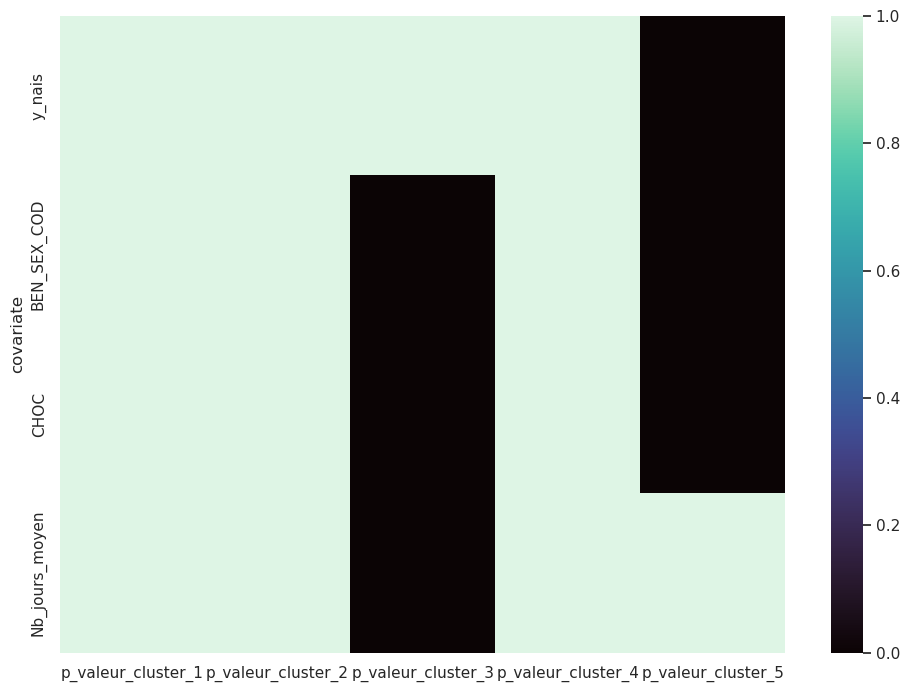

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("darkgrid")
sns.heatmap(P_value_seuil, cmap="mako")

### AIC

In [25]:
for counter, AIC in enumerate(Partial_AIC):
    print( "Cluster_" + str(counter+1 ) + "  Partial AIC : " + str(Partial_AIC[counter]))

Cluster_1  Partial AIC : 8495
Cluster_2  Partial AIC : 41748
Cluster_3  Partial AIC : 39
Cluster_4  Partial AIC : 24015
Cluster_5  Partial AIC : 1773


### Concordance Index

In [26]:
for counter, AIC in enumerate(Liste_concordance_index):
    print( "Cluster_" + str(counter +1) + "  Concordance Index : " + str(Liste_concordance_index[counter]))
print('\n')
print("Moyenne du Concordance Index : " + str(np.mean(Liste_concordance_index)))

Cluster_1  Concordance Index : 0.612
Cluster_2  Concordance Index : 0.64
Cluster_3  Concordance Index : 0.887
Cluster_4  Concordance Index : 0.621
Cluster_5  Concordance Index : 0.543


Moyenne du Concordance Index : 0.6606000000000001


### Intervalle de confiance

In [27]:
Liste_interval

,Interval de confiance du coefficient cluster 1,Interval de confiance du coefficient cluster2,Interval de confiance du coefficient cluster3,Interval de confiance du coefficient cluster4,Interval de confiance du coefficient cluster5
covariate,,,,,
y_nais,"[0.02 ,0.03]","[0.04 ,0.05]","[0.03 ,0.16]","[0.03 ,0.04]","[-0.0 ,0.02]"
BEN_SEX_COD,"[-0.44 ,-0.12]","[-0.3 ,-0.14]","[-1.22 ,2.36]","[-0.37 ,-0.17]","[-0.56 ,0.06]"
CHOC,"[0.05 ,0.66]","[0.77 ,1.13]","[-2.74 ,2.1]","[0.27 ,0.72]","[-0.53 ,0.5]"
Nb_jours_moyen,"[0.07 ,0.12]","[0.02 ,0.03]","[-1.21 ,0.13]","[0.05 ,0.07]","[0.02 ,0.11]"


### Ljung-Box

In [28]:
Liste_ljung_box

,P-valeur Ljung-Box cluster 1,P-valeur Ljung-Box cluster 2,P-valeur Ljung-Box cluster 3,P-valeur Ljung-Box cluster 4,P-valeur Ljung-Box cluster 5
covariate,,,,,
y_nais,0.27,9.442219e-128,0.003859,1.395379e-40,0.186076
BEN_SEX_COD,0.40,6.793022e-08,0.531058,7.446653e-08,0.112558
CHOC,0.44,3.774782e-26,0.795200,1.551129e-05,0.961995
Nb_jours_moyen,0.12,0.000000e+00,0.880000,5.000000e-02,0.080000


In [29]:
Liste_ljung_box_seuil=(Liste_ljung_box[Liste_ljung_box>=0.05] == Liste_ljung_box)*1 + (Liste_ljung_box[Liste_ljung_box<0.05] == Liste_ljung_box)*0 + (pd.isna(Liste_ljung_box))*-1

In [30]:
Liste_ljung_box_seuil

,P-valeur Ljung-Box cluster 1,P-valeur Ljung-Box cluster 2,P-valeur Ljung-Box cluster 3,P-valeur Ljung-Box cluster 4,P-valeur Ljung-Box cluster 5
covariate,,,,,
y_nais,1,0,0,0,1
BEN_SEX_COD,1,0,1,0,1
CHOC,1,0,1,0,1
Nb_jours_moyen,1,0,1,1,1


<Axes: ylabel='covariate'>

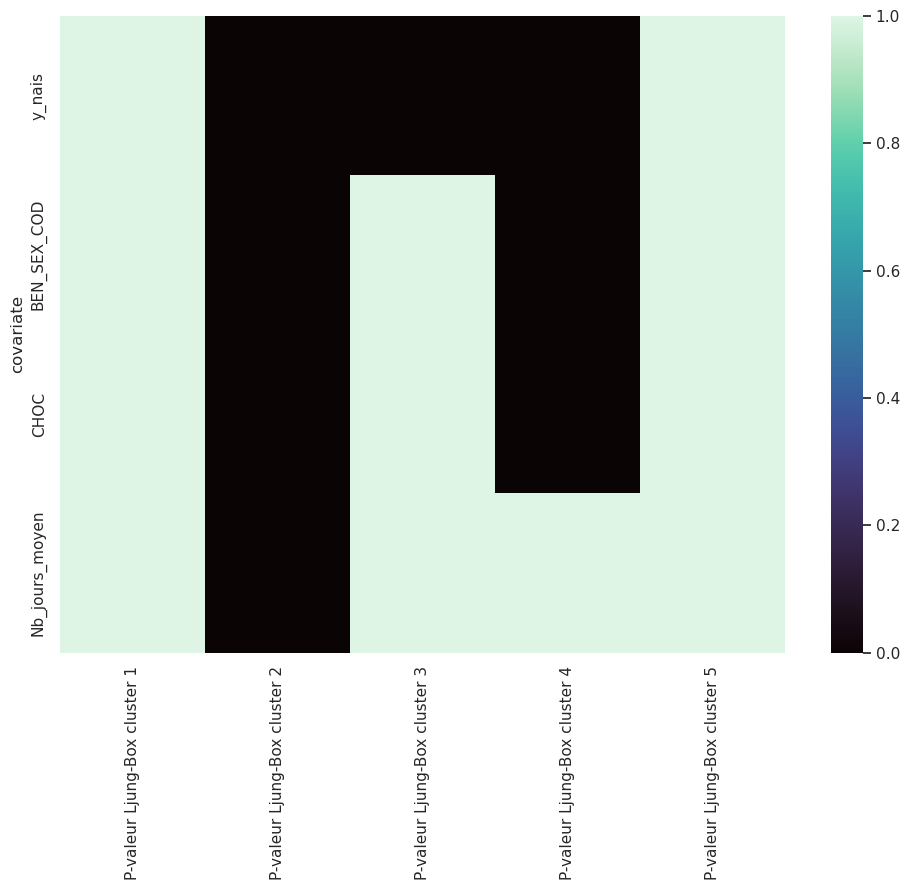

In [31]:
sns.heatmap(Liste_ljung_box_seuil, cmap="mako")

### Test des hasards proportionnels

In [32]:
Rank

,Statistique du test des hasards proportionnels (rank) cluster 1,p_valeur cluster 1,Statistique du test des hasards proportionnels (rank) cluster 2,p_valeur cluster 2,Statistique du test des hasards proportionnels (rank) cluster 3,p_valeur cluster 3,Statistique du test des hasards proportionnels (rank) cluster 4,p_valeur cluster 4,Statistique du test des hasards proportionnels (rank) cluster 5,p_valeur cluster 5
y_nais,9.277647,0.002320,131.141209,2.306046e-30,0.273790,0.600801,29.989539,4.343834e-08,1.427599,0.232157
BEN_SEX_COD,0.045515,0.831060,0.233585,6.288785e-01,1.706922,0.191385,0.306864,5.796110e-01,3.452887,0.063141
CHOC,1.261225,0.261419,51.187774,8.393980e-13,2.293230,0.129939,6.779590,9.220605e-03,0.269193,0.603874
Nb_jours_moyen,14.704679,0.000126,98.440321,3.349689e-23,6.852529,0.008852,25.899485,3.596651e-07,3.577236,0.058577


In [33]:
Rank_seuil=Rank.copy()
Rank_seuil=(Rank[Rank>=0.05] == Rank)*1 + (Rank[Rank<0.05] == Rank)*0 + (pd.isna(Rank))*-1
for i in range (1,Nb_cluster+1):
    Rank_seuil=Rank_seuil.drop(["Statistique du test des hasards proportionnels  (rank) cluster " + str(i)], axis=1)
Rank_seuil

,p_valeur cluster 1,p_valeur cluster 2,p_valeur cluster 3,p_valeur cluster 4,p_valeur cluster 5
y_nais,0,0,1,0,1
BEN_SEX_COD,1,1,1,1,1
CHOC,1,0,1,0,1
Nb_jours_moyen,0,0,0,0,1


<Axes: >

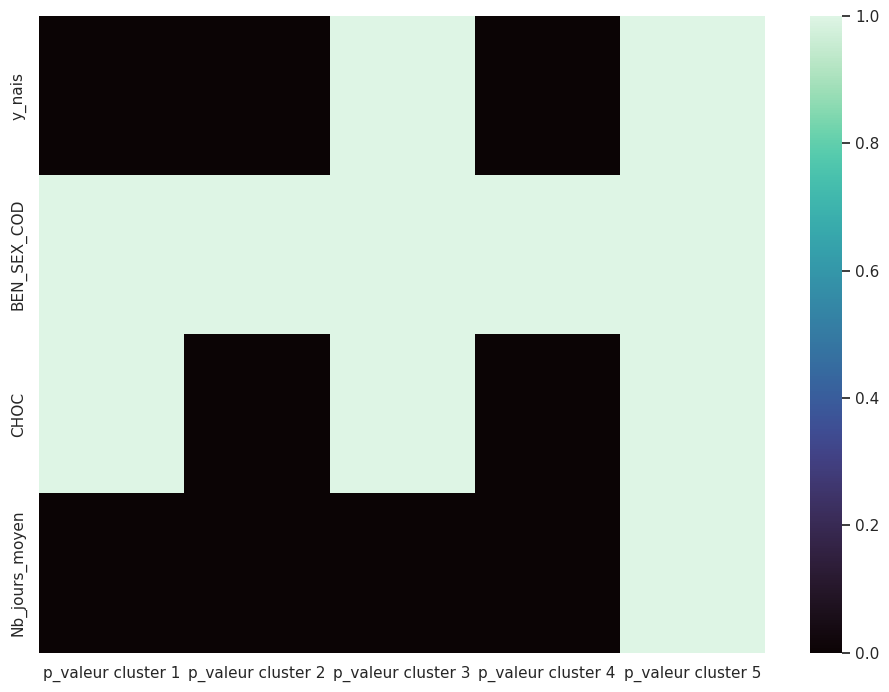

In [34]:
sns.heatmap(Rank_seuil, cmap="mako")

In [35]:
KM

,Statistique du test des hasards proportionnels (km) cluster 1,p_valeur cluster 1,Statistique du test des hasards proportionnels (km) cluster 2,p_valeur cluster 2,Statistique du test des hasards proportionnels (km) cluster 3,p_valeur cluster 3,Statistique du test des hasards proportionnels (km) cluster 4,p_valeur cluster 4,Statistique du test des hasards proportionnels (km) cluster 5,p_valeur cluster 5
y_nais,7.707414,0.005499,129.204232,6.118720e-30,0.017835,0.893760,28.730378,8.318852e-08,1.106266,0.292895
BEN_SEX_COD,0.016783,0.896924,0.172371,6.780132e-01,1.158501,0.281777,0.278889,5.974301e-01,3.891531,0.048530
CHOC,1.056993,0.303902,49.928837,1.594243e-12,2.271147,0.131802,5.716036,1.681064e-02,0.365624,0.545399
Nb_jours_moyen,12.928744,0.000324,94.362570,2.627133e-22,5.059463,0.024492,24.567990,7.173348e-07,3.998202,0.045549


In [36]:
KM_seuil=KM.copy()
KM_seuil=(KM[KM>=0.05] == KM)*1 + (KM[KM<0.05] == KM)*0 + (pd.isna(KM))*-1
for i in range (1,Nb_cluster+1):
    KM_seuil=KM_seuil.drop(["Statistique du test des hasards proportionnels  (km) cluster " + str(i)], axis=1)
KM_seuil

,p_valeur cluster 1,p_valeur cluster 2,p_valeur cluster 3,p_valeur cluster 4,p_valeur cluster 5
y_nais,0,0,1,0,1
BEN_SEX_COD,1,1,1,1,0
CHOC,1,0,1,0,1
Nb_jours_moyen,0,0,0,0,0


<Axes: >

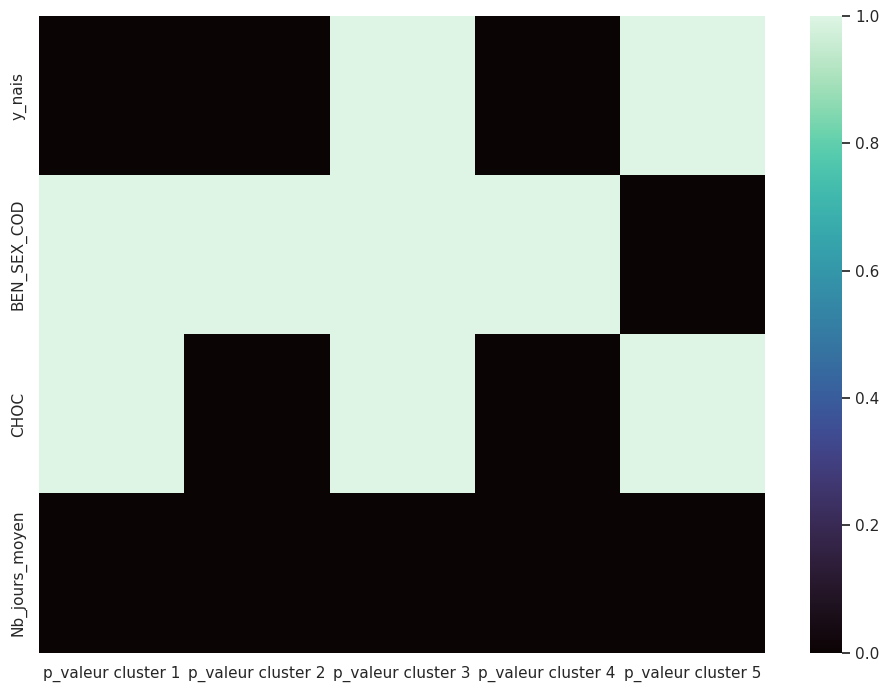

In [37]:
sns.heatmap(KM_seuil, cmap="mako")

### Plot Intersection

In [38]:
Intersection =KM_seuil.astype(int).values+ Rank_seuil.astype(int).values + Liste_ljung_box_seuil.astype(int).values
Intersection

array([[1, 0, 2, 0, 3],
       [3, 2, 3, 2, 2],
       [3, 0, 3, 0, 3],
       [1, 0, 1, 1, 2]])

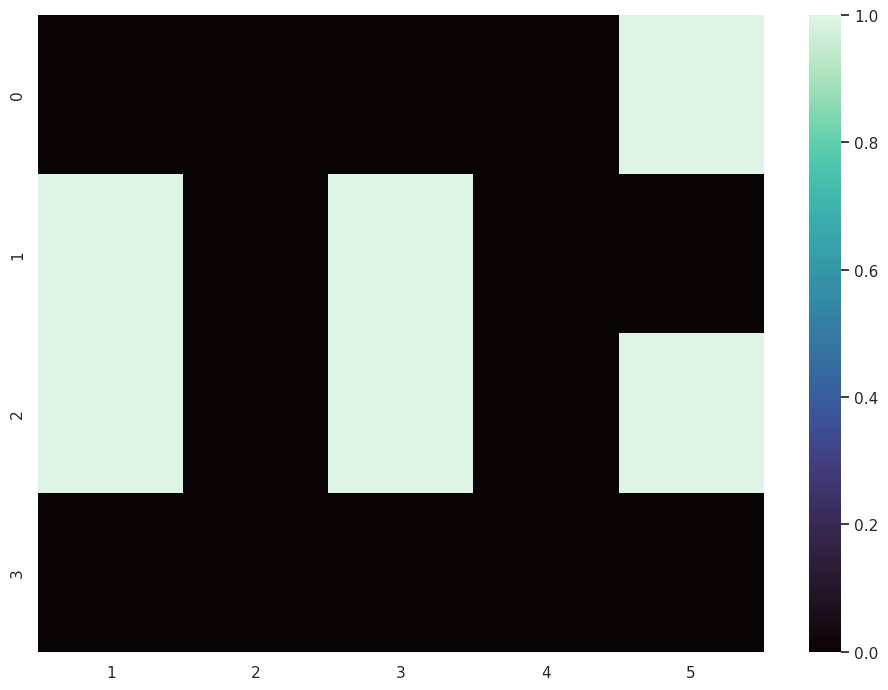

In [40]:
ax=sns.heatmap(Intersection==3, cmap="mako")
ax.set_xticklabels(range(1,nb_cluster+1))
plt.show()